# OpenVINO toolkit hands-on

### What are we going to do here?

* Model Optimizer - tool that facilitates the transition between the training and deployment environment, performs static model analysis, and adjusts deep learning models for optimal execution on end-point target devices.
* Inference Engine - a unified API to allow high performance inference on many hardware.
* Accuracy Checker - tool to measure accuracy of a model.
* Post-Training Optimization Toolkit - tool designed to convert a model into a more hardware-friendly representation by applying specific methods that do not require re-training, for example, post-training quantization.
* Benchmark Application - Python sample for getting best performance with the OpenVINO Inference Engine.
* Python API for Inference Engine

## Step 0. Prerequisites.

To do a quantization you need pre-trained model in IR format and calibration dataset. Let's prepare both components in this step. In this tutorial, we'll use SimpLeNet - very simple model trained specially for sample purposes on cifar-10 dataset. 

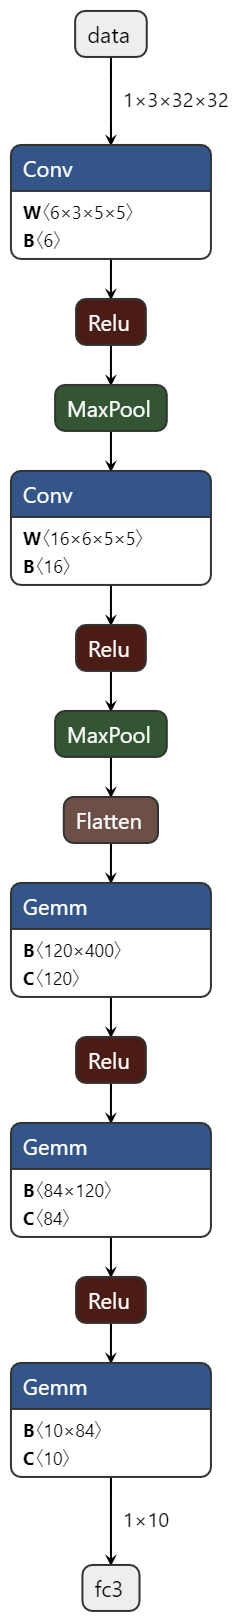

In [28]:
from IPython.display import Image

Image(filename =r'samplenet.png')

### Step 0.1. Converting model to IR.

SampLeNet is distributed as a part of OpenVINO and used in AccuracyChecker sample.

In [3]:
!ls /opt/intel/openvino/deployment_tools/open_model_zoo/tools/accuracy_checker/data/test_models/

pytorch_model	       SampLeNet.caffemodel  samplenet-symbol.json
samplenet-0000.params  samplenet.onnx	     SampLeNet.xml
SampLeNet.bin	       samplenet.pb
SampLeNet.blob	       SampLeNet.prototxt


Here are SampleNets trained with different frameworks. Let's take Caffe one and convert it to IR.
BKM: To achieve proper accuracy always check what normalization was applied on the model training stage. Model Optimizer can apply mean and scale values if appropriate. This information can be obtained from the model training script.
In our case means and scales were applied to the model. 

In [4]:
!/opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model /opt/intel/openvino/deployment_tools/open_model_zoo/tools/accuracy_checker/data/test_models/SampLeNet.caffemodel \
--output_dir IR \
--mean_values [125.307,122.961,113.8575] \
--scale_values [51.5865,50.847,51.255]

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/opt/intel/openvino/deployment_tools/open_model_zoo/tools/accuracy_checker/data/test_models/SampLeNet.caffemodel
	- Path for generated IR: 	/home/u41987/My-Notebooks/POT_tutorial/IR
	- IR output name: 	SampLeNet
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[125.307,122.961,113.8575]
	- Scale values: 	[51.5865,50.847,51.255]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.proto: 	/opt/intel/openvino/deployment_tools/model_optimizer/mo/front/caffe/proto
	- Enab

More info here: [Model Optimizer guide](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html)

### Extra: Inference in couple lines

In [13]:
from openvino import inference_engine as ie

import numpy as np

# Create an instance of the OpenVINO Inference Engine Core 
# This is the key module of the OpenVINO Inference Engine
ie_core = ie.IECore()

# Read a network from the Intermediate Representation (IR)
network = ie_core.read_network('IR/SampLeNet.xml', 'IR/SampLeNet.bin')

print(network.input_info['data'].input_data.shape)

# Get input shape of the network
input_shape = network.input_info['data'].input_data.shape

# Load the network that was read from the Intermediate Representation (IR) 
# to the CPU device 
network_loaded_on_device = ie_core.load_network(network=network, device_name='CPU')

# Start an inference of the loaded network and return output data
network_loaded_on_device.infer(inputs={input_layer: np.random.rand(*input_shape)})

[1, 3, 32, 32]


{'fc3': array([[ 0.76805073, -4.5616274 ,  1.791259  ,  2.5688696 ,  0.08077562,
          0.84494245,  0.90294826, -0.9394025 ,  0.40436044, -1.8596628 ]],
       dtype=float32)}

### Step 0.2. Getting the dataset.

The dataset is an essential part of quantization. It's needed to collect calibration statistics and measure accuracy using accuracy chcker tool. That's why big portion of information we'll need further is about the dataset on which model was trained
Let's download download and prepare that. 
In our example the model was trained on cifar10 which consists of 60000 32x32 colour images in 10 classes.

In [14]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-09-03 13:48:26--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  19.0MB/s    in 11s     

2020-09-03 13:48:38 (14.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



Unzip the data

In [15]:
!tar -xzf cifar-10-python.tar.gz

In [16]:
!ls cifar-10-batches-py

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


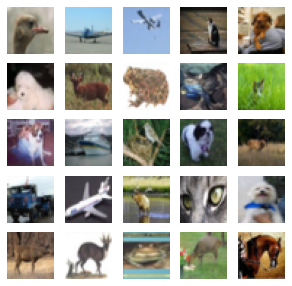

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from six.moves import cPickle 

meta_f = open('cifar-10-batches-py/batches.meta', 'rb')
meta = cPickle.load(meta_f,encoding='latin1')

f = open('cifar-10-batches-py/data_batch_1', 'rb')
datadict = cPickle.load(f,encoding='latin1')
f.close()
X = datadict["data"] 
Y = datadict['labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(5,5))
labels = []
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        labels.append(Y[i])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

## Step 1. Getting familiar with POT. 

This notebook demonstrates basic capabilities of POT:
* POT configuration files structure
* How to run POT in simplified mode
* How to measure accuracy of FP32, INT8 models using POT config 
* How to create your own POT config
* How to properly benchmark the workload

Lets check how POT is working and how to work with that.

In [6]:
!pot -h

usage: pot [-h] -c CONFIG [-e] [--output-dir OUTPUT_DIR] [-d]
           [--log-level {CRITICAL,ERROR,WARNING,INFO,DEBUG}] [--progress-bar]
           [--keep_uncompressed_weights]

Post-training Compression Toolkit

optional arguments:
  -h, --help            show this help message and exit
  -c CONFIG, --config CONFIG
                        Path to a config file with task/model-specific
                        parameters
  -e, --evaluate        Whether to evaluate model on whole dataset
  --output-dir OUTPUT_DIR
                        The directory where models are saved. Default:
                        ./results
  -d, --direct-dump     Flag to save files without sub folders with algo names
  --log-level {CRITICAL,ERROR,WARNING,INFO,DEBUG}
                        Log level to print
  --progress-bar        Disable CL logging and enable progress bar
  --keep_uncompressed_weights
                        Keep Convolution, Deconvolution and FullyConnected
                        weight

As you can see, all "magic" is inside the config.json file, lets look into that. 
OpenVINO has POT config templates and config examples inside. 

In [7]:
!ls /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs

calibration_dataset_template.json  template_accuracy_aware_quantization.json
examples			   template_default_quantization.json
README.md			   template_tpe.json


Templates (template_accuracy_aware_quantization.json, template_default_quantization.json, template_tpe.json) contain all possible POT parameters with very detailed explanation. If you need no know meaning of certain parameter, this is a goos resource to learn. 
Examples provide accuracy_checker, qunatization and sparsity configs for several well-known public topologies. This is good material to getting started if you need to quantize models listed here or similar models. 

In [8]:
!ls /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/examples/

accuracy_checker  quantization	README.md  sparsity


In [9]:
!ls /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/examples/accuracy_checker

densnet_121.yaml		     mobilenet_v2.yaml
east_resnet_v1_50.yaml		     ncf.yaml
faster_rcnn_resnet101_coco.yaml      ssd_mobilenet_v1.yaml
faster_rcnn_resnet50_coco.yaml	     ssd_resnet34.yaml
mask_rcnn_resnet50_atrous_coco.yaml  ssd_resnet50_512.yml
mobilenet_v1_tf.yaml


In [10]:
!ls /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/examples/quantization

classification	  optimization	  segmentation
object_detection  recommendation  text_detection


In [11]:
!ls /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/examples/quantization/classification

densnet_121_caffe_int8.json		 mobilenetV2_tf_int8.json
inceptionV3_tf_int8.json		 mobilenetV2_tf_int8_simple_mode.json
mobilenetV1_tf_int8.json		 mobilenetV2_tf_int8_sqnr.json
mobilenetV2_engine_config.json		 se_resnet50_pytorch_int8.json
mobilenetV2_pytorch_int8.json		 squeezenet1_1_pytorch_int8.json
mobilenetV2_tf_int8_accuracy_aware.json


In [12]:
!ls /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/examples/sparsity

resnet-50-pytorch.json	ssd_resnet50_512.json


Let's take a look into the DefaultQuantization template

In [13]:
!cat /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/template_default_quantization.json

{
    /* Model */
    "model": {
        "model_name": "model_name", // Model name
        "model": "<MODEL_PATH>", // Path to model (.xml format)
        "weights": "<PATH_TO_WEIGHTS>" // Path to weights (.bin format)
    },
    /* Parameters of the engine used for model inference. */
    /* Post-Training Optimization Tool supports engine based on accuracy checker and custom engine.
       For custom engine you should specify your own set of parameters.
       The engine based on accuracy checker uses accuracy checker parameters. You can specify the parameters
       via accuracy checker config file or directly in engine section.
       More information about accuracy checker parameters can be found here:
       https://github.com/opencv/open_model_zoo/tree/master/tools/accuracy_checker */
    "engine": {
        // Accuracy checker mode (default)
        "stat_requests_number": 8,  // Number of requests during statistcs collection
        "eval_requests_number": 8,  // Number of requ

It contains 3 main sections: "model", "engine", "compression".

"model" is a simpliest, it keeps model name and path to IR.

"engine" includes information of how the model will be executed. There are 2 modes: "simplified" - to run basic scenarios to roughly estimate performance gain and doesn't requre dataset labels; and "accuracy checker" - allows to produce more accurately quantized model, allows to tune the image preprocessing, reading, etc., labeled dataset required.

"compression" section should have all needed optimization algorithm onformation. 

More detailed information is available at the README.md file.

In [14]:
!cat /opt/intel/openvino/deployment_tools/tools/post_training_optimization_toolkit/configs/README.md

# Configuration File Description

The toolkit is designed to work with the configuration file where all the parameters required for the optimization are specified. These parameters are organized as a dictionary and stored in
a JSON file. JSON file allows using comments that are supported by the `jstyleson` Python* package.
Logically all parameters are divided into three groups:
- **Model parameters** that are related to the model definition (e.g. model name, model path, etc.)
- **Engine parameters** that define parameters of the engine which is responsible for the model inference and data preparation used for optimization and evaluation (e.g. preprocessing parameters, dataset path, etc.)
- **Compression parameters** that are related to the optimization algorithm (e.g. algorithm name and specific parameters)

## Model Parameters

This section contains only three parameters:
- `"model_name"` - string parameter that defines a model name, e.g. `"MobileNetV2"`
- `"model"` - string parameter

Lets run POT in different modes, compare them and practice with POT configs creation.

## Step 2. Rough INT8 performance estimation (simplified mode). 

Let's imagine if we have the model and we're not satisfied with it's performance level. Low precision quantization is one of the optimization options. But not all models are well-qunatizable - sometimes the performance gain can be insignificant and use this approach is a waste of the time. It's really depends on the workload model/data etc.. You can quickly check whether it's worth to apply quantization technique or not using "simplified mode". Let's do that.

First of all, lets estimate the performance of the full pfecision (FP32) model using benchmark app. Benchmark app is a specual tool recommended for performance estimation. This is how to work with the tool:

In [15]:
!python3 /opt/intel/openvino/deployment_tools/tools/benchmark_tool/benchmark_app.py -h

[Step 1/11] Parsing and validating input arguments
usage: benchmark_app.py [-h [HELP]] [-i PATHS_TO_INPUT [PATHS_TO_INPUT ...]]
                        -m PATH_TO_MODEL [-d TARGET_DEVICE]
                        [-l PATH_TO_EXTENSION] [-c PATH_TO_CLDNN_CONFIG]
                        [-api {sync,async}] [-niter NUMBER_ITERATIONS]
                        [-nireq NUMBER_INFER_REQUESTS] [-b BATCH_SIZE]
                        [-stream_output [STREAM_OUTPUT]] [-t TIME]
                        [-progress [PROGRESS]] [-nstreams NUMBER_STREAMS]
                        [-nthreads NUMBER_THREADS] [-pin {YES,NO,NUMA}]
                        [--exec_graph_path EXEC_GRAPH_PATH]
                        [-pc [PERF_COUNTS]]
                        [--report_type {no_counters,average_counters,detailed_counters}]
                        [--report_folder REPORT_FOLDER]

Options:
  -h [HELP], --help [HELP]
                        Show this help message and exit.
  -i PATHS_TO_INPUT [PATHS_TO_INPUT ...],

In [29]:
!python3 /opt/intel/openvino/deployment_tools/tools/benchmark_tool/benchmark_app.py -m IR/SampLeNet.xml -i cifar-10-python/01_cat.png

[Step 1/11] Parsing and validating input arguments
/opt/intel/openvino_2020.4.287/python/python3.6/openvino/tools/benchmark/main.py:29: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(" -nstreams default value is determined automatically for a device. "
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading Inference Engine
[ INFO ] InferenceEngine:
         API version............. 2.1.2020.4.0-359-21e092122f4-releases/2020/4
[ INFO ] Device info
         CPU
         MKLDNNPlugin............ version 2.1
         Build................... 2020.4.0-359-21e092122f4-releases/2020/4

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually prov

That's great throughput and latency numbers, but lets see can we improve it or not. So, we need to create POT config for that purpose. To use simplified mode we need specify "type": "simplified" and "data_source": "path/to/the/dataset" fields at the compression section. 

In [17]:
!cat basic_materials/SampLeNet_simplified.json

{
  "model": {
    "model_name": "SampLeNet_simplified",
    "model": "IR/SampLeNet.xml",
    "weights": "IR/SampLeNet.bin"
  },
  "engine": {
    "type": "simplified",
    "data_source": "cifar-10-python"
  },
  "compression": {
    "target_device": "CPU",
    "algorithms": [
      {
        "name": "DefaultQuantization",
        "params": {
          "preset": "performance",
          "stat_subset_size": 300
        }
      }
    ]
  }
}

Let's run quantization in simplified mode. Using "-d" option to simplify results stirage and further reuse of the models by benchmark app.

In [18]:
!pot -c basic_materials/SampLeNet_simplified.json -d

INFO:app.run:Output log dir: ./results
INFO:app.run:Creating pipeline:
 Algorithm: DefaultQuantization
 Parameters:
	preset                     : performance
	stat_subset_size           : 300
	target_device              : CPU
	exec_log_dir               : ./results
INFO:compression.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:compression.statistics.collector:Computing statistics finished
INFO:compression.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:compression.statistics.collector:Start computing statistics for algorithms : ActivationChannelAlignment
INFO:compression.statistics.collector:Computing statistics finished
INFO:compression.statistics.collector:Start computing statistics for algorithms : MinMaxQuantization,FastBiasCorrection
INFO:compression.statistics.collector:Computing statistics finished
INFO:compression.pipeline.pipeline:Finished: DefaultQuantization


Rough estimation of how we can benefit from INT8:

In [19]:
!python3 /opt/intel/openvino/deployment_tools/tools/benchmark_tool/benchmark_app.py -m results/optimized/SampLeNet_simplified.xml -i cifar-10-python/01_cat.png

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading Inference Engine
[ INFO ] InferenceEngine:
         API version............. 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
[ INFO ] Device info
         CPU
         MKLDNNPlugin............ version 2.1
         Build................... 2020.3.0-3467-15f2c61a-releases/2020/3

[Step 3/11] Reading the Intermediate Representation network
[ INFO ] Read network took 14.82 ms
[Step 4/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1
[Step 5/11] Configuring input of the model
[Step 6/11] Setting device configuration
[Step 7/11] Loading the model to the device
[ INFO ] Load network took 73.93 ms
[Step 8/11] Setting optimal runtime parameters
[Step 9/11

## Step 3. Measuring accuracy of FP32 model. Accuracy Checker configuration. 

Looks like we can dramatically accelerate our workload. But what's about accuracy. If we're able to run the model with benchmark it's not guaranteed that the inference result is correct. To confirm that the model output is correct you can check visually/manually, but we're offering Accuracy Checker tool which estimates accuracy metrics of given model on given dataset. It can be used directly using accuracy_check alias or call it from the POT config. 

In [20]:
!accuracy_check -h

02:42:42 accuracy_checker WARNING: /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])

02:42:42 accuracy_checker WARNING: /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

02:42:42 accuracy_checker WARNING: /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

02:42:42 a

It was how to use Accuracy Checker directly, it uses it's own .yaml configuration files. But to avoid producing too many configs, here we'll call it from "engine" section at the same POT config. Lets change it like this: 

In [21]:
!cat basic_materials/SampLeNet_FP32.json

{
  "model": {
    "model_name": "SampLeNet_FP32",
    "model": "IR/SampLeNet.xml",
    "weights": "IR/SampLeNet.bin"
  },
  "engine": {
    "launchers": [
      {
        "framework": "dlsdk",
        "device": "CPU",
        "adapter": "classification"
      }
    ],
    "datasets": [
      {
        "name": "classification_dataset",
        "data_source": "cifar-10-python",
        "annotation_conversion": {
          "converter": "cifar",
          "data_batch_file": "cifar-10-batches-py/test_batch",
          "convert_images": true,
          "converted_images_dir": "cifar-10-python",
          "num_classes": 10
        },
        "reader": "opencv_imread",
        "preprocessing": [
            {
                "type": "bgr_to_rgb"
            }
        ],
        "metrics": [
          {
            "name": "accuracy@top1",
            "type": "accuracy",
            "top_k": 1
          },
          {
            "name": "accuracy@top5",
            "type": "accuracy",
       

**Accuracy Checker configuration files have the following parts:**

* **Launchers** are the inference backend. It can be OpenVINO Inference Engine or fameworks like Tensorflow, Pytorch, ONNX Runtime, etc. So, choosing different launchers you can compare an accuracy of the model inferred using OpenVINO and by the framemowork it was trained. Here you can also specify inference device. At the example above we're using Inference Engine Launcher on CPU. Click [here](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_README.html) to see full launchers list.

   **Please note that for quanization via POT OpenVINO Inference Engine is  only available inference backend.**

* **Adapters**. Adapter converts network infer output to metric specific format. [Here are available adapters](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_accuracy_checker_adapters_README.html). We have simple classification model, so, our adapter is "classification". 

* **Annotation Converters**. Today there are thousants of datasets and eche has its own annotation format. AC uses it's own internal dataset annotation format. So, annotation converted convers the dataset annotation from its fromat to AC one. [Check supported datasets](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_accuracy_checker_annotation_converters_README.html)
    At this example we're using cifar10 - lets specify that, and don't forget put the numper of classes.

* **Readers**. It's how images from the dataset will be read. Look for [implemented readers](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_accuracy_checker_data_readers_README.html)
We're going to read RGB images in .png format - several readers from the list works for us. OpenCV imread is the default one, we'll use because the same reader was used on the training stage - so, that makes our experimets more precise.

* [Preprocesors](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_accuracy_checker_preprocessor_README.html) and [Postprocessors](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_accuracy_checker_postprocessor_README.html) - addotional calibration datased pre- and post-processing can be added if appropriate (it that's done in model training). The most popular preprocessing is resize images to fit model input shape. In our case it is not required because images already have the same size like model input. We alredy added some normalization (scale and mean values) on Model Optimizer side, so, we don't need to put it here. If we forget to add "--mean" and -"--scale" at the MO command line, we can do it here. Only one preprocessing we should add is BGR to RGB conversion, because topology is trained on RGB images, but OpenCV reader (opencv_imread) reads in BGR.

* **Metrics**. It's the way of accuracy measuring. Different CV tasks like classification, detection, segmentation, etc has diferent approaches to measure accuracy. You can choose among [these metrics](https://docs.openvinotoolkit.org/latest/_tools_accuracy_checker_accuracy_checker_metrics_README.html).
Our SampLeNet is a classification model, cifar is classification dataset, so, lets apply most popular classification metrics: `top1` and `top5`. 

To calculate accuracy of full precision model using POT and Accuracy Checker - leave empty "compression" section at the POT config and add "-e" (evaluation) parameter to the command line. 

In [22]:
!pot -c basic_materials/SampLeNet_FP32.json -e -d

INFO:app.run:Output log dir: ./results
INFO:app.run:Creating pipeline:
IE version: 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
Loaded CPU plugin version:
    CPU - MKLDNNPlugin: 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
INFO:compression.pipeline.pipeline:Evaluation of generated model
INFO:compression.engines.ac_engine:Start inference on the whole dataset
Total dataset size: 10000
1000 / 10000 processed in 1.995s
2000 / 10000 processed in 1.924s
3000 / 10000 processed in 1.978s
4000 / 10000 processed in 1.951s
5000 / 10000 processed in 1.979s
6000 / 10000 processed in 1.945s
7000 / 10000 processed in 1.949s
8000 / 10000 processed in 1.951s
9000 / 10000 processed in 1.941s
10000 / 10000 processed in 1.932s
10000 objects processed in 19.547 seconds
INFO:compression.engines.ac_engine:Inference finished
INFO:app.run:accuracy@top1              : 0.7502
INFO:app.run:accuracy@top5              : 0.9822


FP32 model accuracy level is exactly the same with Caffe output, so, our model is running correctly. Lets quantize it.

## Step 4. Running calibration algorithms. Evaluating it's accuracy and perfromance.

Currently (OpenVINO 2020.2) there are 2 "production quality" quantization algorithms: DefaultQuantization and AccuracyAwareQuantization. Lets read how do they work at the README file below: 

[Quantization overview](https://docs.openvinotoolkit.org/latest/pot_compression_algorithms_quantization_README.html)

### Step 4.1 Running DefaultQuantization

Let's apply DefaultQuantization, filing "compression" section as at the config below:

In [25]:
!cat basic_materials/SampLeNet_DefaultQuantization.json

{
  "model": {
    "model_name": "SampLeNet_DefaultQuantization",
    "model": "IR/SampLeNet.xml",
    "weights": "IR/SampLeNet.bin"
  },
  "engine": {
    "launchers": [
      {
        "framework": "dlsdk",
        "device": "CPU",
        "adapter": "classification"
      }
    ],
    "datasets": [
      {
        "name": "classification_dataset",
        "data_source": "cifar-10-python",
        "annotation_conversion": {
          "converter": "cifar",
          "data_batch_file": "cifar-10-batches-py/test_batch",
          "convert_images": true,
          "converted_images_dir": "cifar-10-python",
          "num_classes": 10
        },
        "reader": "opencv_imread",
        "preprocessing": [
            {
                "type": "bgr_to_rgb"
            }
        ],
        "metrics": [
          {
            "name": "accuracy@top1",
            "type": "accuracy",
            "top_k": 1
          },
          {
            "name": "accuracy@top5",
            "type": "acc

Running it, again using "-e" option to see accuracy results.

In [26]:
!pot -c basic_materials/SampLeNet_DefaultQuantization.json -e -d

INFO:app.run:Output log dir: ./results
INFO:app.run:Creating pipeline:
 Algorithm: DefaultQuantization
 Parameters:
	preset                     : performance
	stat_subset_size           : 300
	target_device              : CPU
	exec_log_dir               : ./results
IE version: 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
Loaded CPU plugin version:
    CPU - MKLDNNPlugin: 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
INFO:compression.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:compression.statistics.collector:Computing statistics finished
INFO:compression.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:compression.statistics.collector:Start computing statistics for algorithms : ActivationChannelAlignment
INFO:compression.statistics.collector:Computing statistics finished
INFO:compression.statistics.collector:Start computing statistics for algorithms : MinMaxQuantization,FastBiasCorrection
INFO:compression.statistics.collector:Computin

Accuracy doesn't deviate so much from FP32 model - we can stop here, but lets' check AccuracyAwareAlgorithm. Just change the algo name in compression section.

### Step 4.2 Running AccuracyAwareQuantization

In [27]:
!cat basic_materials/SampLeNet_AccuracyAwareQuantization.json

{
  "model": {
    "model_name": "SampLeNet_AccuracyAware",
    "model": "IR/SampLeNet.xml",
    "weights": "IR/SampLeNet.bin"
  },
  "engine": {
    "launchers": [
      {
        "framework": "dlsdk",
        "device": "CPU",
        "adapter": "classification"
      }
    ],
    "datasets": [
      {
        "name": "classification_dataset",
        "data_source": "cifar-10-python",
        "annotation_conversion": {
          "converter": "cifar",
          "data_batch_file": "cifar-10-batches-py/test_batch",
          "convert_images": true,
          "converted_images_dir": "cifar-10-python",
          "num_classes": 10
        },
        "reader": "opencv_imread",
        "preprocessing": [
            {
                "type": "bgr_to_rgb"
            }
        ],
        "metrics": [
          {
            "name": "accuracy@top1",
            "type": "accuracy",
            "top_k": 1
          },
          {
            "name": "accuracy@top5",
            "type": "accuracy"

In [29]:
!pot -c basic_materials/SampLeNet_AccuracyAwareQuantization.json -e -d

INFO:app.run:Output log dir: ./results
INFO:app.run:Creating pipeline:
 Algorithm: AccuracyAwareQuantization
 Parameters:
	preset                     : performance
	stat_subset_size           : 300
	target_device              : CPU
	exec_log_dir               : ./results
IE version: 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
Loaded CPU plugin version:
    CPU - MKLDNNPlugin: 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
INFO:compression.statistics.collector:Start computing statistics for algorithms : AccuracyAwareQuantization
INFO:compression.statistics.collector:Computing statistics finished
INFO:compression.pipeline.pipeline:Start algorithm: AccuracyAwareQuantization
INFO:compression.algorithms.quantization.accuracy_aware.algorithm:Start original model inference
INFO:compression.engines.ac_engine:Start inference of 10000 images
Total dataset size: 10000
1000 / 10000 processed in 1.981s
2000 / 10000 processed in 1.974s
3000 / 10000 processed in 1.980s
4000 / 10000 processed in 1.963s
500

AccuracyAwareQuantization produced INT8 model with the same accuracy level with default one.

Now it's time to compare performance level of quantized model using Benchmark App:

In [30]:
!python3 /opt/intel/openvino/deployment_tools/tools/benchmark_tool/benchmark_app.py -m results/optimized/SampLeNet_DefaultQuantization.xml

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading Inference Engine
[ INFO ] InferenceEngine:
         API version............. 2.1.2020.3.0-3467-15f2c61a-releases/2020/3
[ INFO ] Device info
         CPU
         MKLDNNPlugin............ version 2.1
         Build................... 2020.3.0-3467-15f2c61a-releases/2020/3

[Step 3/11] Reading the Intermediate Representation network
[ INFO ] Read network took 13.90 ms
[Step 4/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1
[Step 5/11] Configuring input of the model
[Step 6/11] Setting device configuration
[Step 7/11] Loading the model to the device
[ INFO ] Load network took 68.42 ms
[Step 8/11] Setting optimal runtime parameters
[Step 9/11

Looks like we have good performance gain!